### We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Besides that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.
### As said above, and the goal is to predict employee retention and understand its main drivers. Specifically, you should:
#### (1) Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 $2000$ people have joined company 1 and $1000$ of them have already quit, then company headcount on 2012/03/02 for company 1 would be $1000$. You should create a table with 3 columns: day, employee_headcount, company_id.

#### (2) What are the main factors that drive employee churn? Do they make sense? Explain your findings.

#### (3) If you could add to this data set just one variable that could help explain employee churn, what would that be?

### Load the package would be used

In [1]:
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)

import numpy as np

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OIsolationForestEstimator
from h2o.tree import H2OTree

### Read in the data set

In [2]:
dat0 = pd.read_csv("../Datasets/employee_retention_data.csv")
print(dat0.head())

   employee_id  company_id              dept  seniority    salary   join_date   quit_date
0      13021.0           7  customer_service         28   89000.0  2014-03-24  2015-10-30
1     825355.0           7         marketing         20  183000.0  2013-04-29  2014-04-04
2     927315.0           4         marketing         14  101000.0  2014-10-13         NaN
3     662910.0           7  customer_service         20  115000.0  2012-05-14  2013-06-07
4     256971.0           2      data_science         23  276000.0  2011-10-17  2014-08-22


### Look into data set

In [3]:
print(dat0.info())
dat0["join_date"] = pd.to_datetime(dat0["join_date"])
dat0["quit_date"] = pd.to_datetime(dat0["quit_date"])
print(dat0.info())
print(dat0.describe(include = "all"))
dat0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB
None
          employee_id    company_id              dept     seniority         salary            joi

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


### Answer questions

#### You should create a table with 3 columns: day, employee_headcount, company_id.

In [4]:
#### Create list of unique dates for the tables
unique_dates = pd.date_range(start = "2011/01/24", end = "2015/12/13")

#### Create list of unique companies
unique_companies = dat0["company_id"].unique()

#### Cross join to get all combinations of dates and companies
dat_headcount = pd.MultiIndex.from_product([unique_dates, unique_companies], names = ["date", "company_id"])
dat_headcount = pd.DataFrame(index = dat_headcount).reset_index()

#### For each company/day, get how many people quit/got hired on that day
dat_join = dat0.groupby(["join_date", "company_id"]).size().reset_index(name = "join_count")
dat_join.columns.values[0] = "date"
dat_quit = dat0.groupby(["quit_date", "company_id"]).size().reset_index(name = "quit_count")
dat_quit.columns.values[0] = "date"

#### Left join the headcount set to dat_join and then dat_quit
dat_headcount = pd.merge(dat_headcount, dat_join, on = ["date", "company_id"], how = "left")
dat_headcount = pd.merge(dat_headcount, dat_quit, on = ["date", "company_id"], how = "left")

#### Replace the NAs with 0
dat_headcount.fillna(0, inplace = True)

#### Get the cummulative sums of join and quit
dat_headcount["cumsum_join"] = dat_headcount.groupby(["company_id"])["join_count"].apply(lambda x: x.cumsum())
dat_headcount["cumsum_quit"] = dat_headcount.groupby(["company_id"])["quit_count"].apply(lambda x: x.cumsum())

#### For each company and each date, take join_count - quit_count
dat_headcount["count"] = dat_headcount["cumsum_join"] - dat_headcount["cumsum_quit"]
dat_headcount_table = dat_headcount[["date", "company_id", "count"]]

#### Check
print(dat_headcount_table.query("company_id == 1").head(10))

          date  company_id  count
4   2011-01-24           1   25.0
16  2011-01-25           1   27.0
28  2011-01-26           1   29.0
40  2011-01-27           1   29.0
52  2011-01-28           1   29.0
64  2011-01-29           1   29.0
76  2011-01-30           1   29.0
88  2011-01-31           1   59.0
100 2011-02-01           1   66.0
112 2011-02-02           1   67.0


#### (2) What are the main factors that drive employee churn? Do they make sense? Explain your findings.

##### Length of employment/days

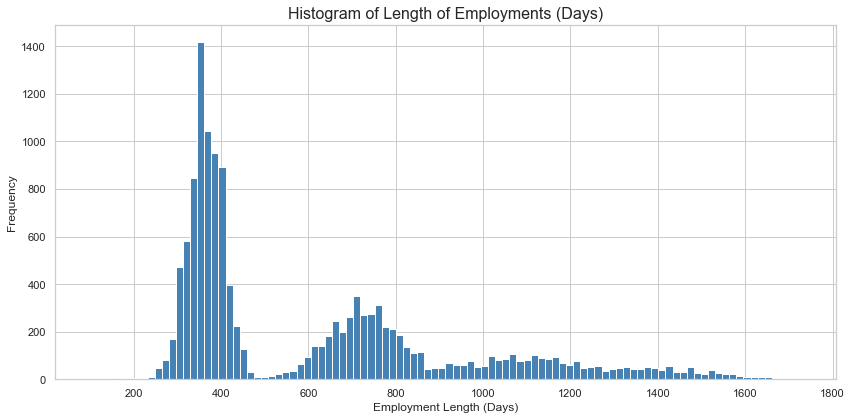

In [5]:
dat0["employment_length"] = (dat0["quit_date"] - dat0["join_date"]).astype("timedelta64[D]")
plt.figure(figsize = [12, 6])
plt.hist(dat0["employment_length"].dropna(), bins = 100, color = "steelblue")
plt.title("Histogram of Length of Employments (Days)", fontsize = 16)
plt.xlabel("Employment Length (Days)", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.show()

##### Week of year

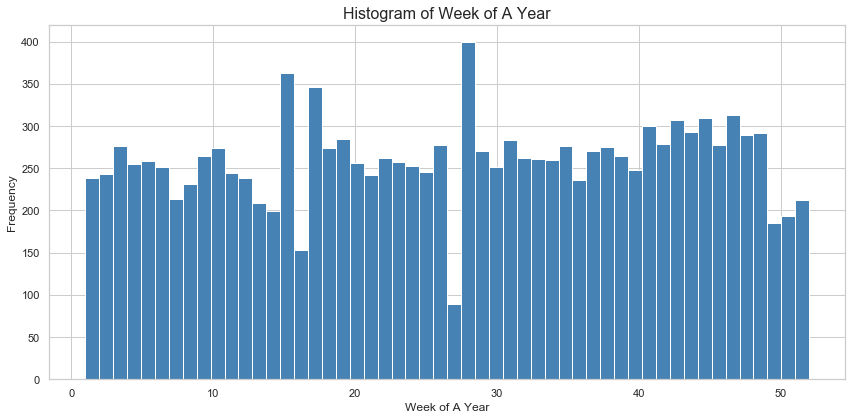

In [6]:
dat0["week_of_year"] = dat0["quit_date"].dt.week
plt.figure(figsize = [12, 6])
plt.hist(dat0["week_of_year"].dropna(), bins = 52, color = "steelblue")
plt.title("Histogram of Week of A Year", fontsize = 16)
plt.xlabel("Week of A Year", fontsize = 12)
plt.ylabel("Frequency", fontsize = 12)
plt.show()

#### Build a classifier

In [7]:
dat0 = dat0[dat0["join_date"] < datetime.strptime("2015/12/13", "%Y/%m/%d") - timedelta(days = (365 + 31))]
dat0["early_quitter"] = np.where((dat0["employment_length"] > 396) | (np.isnan(dat0["employment_length"])), 0, 1)

In [8]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.1" 2019-10-15; Java(TM) SE Runtime Environment (build 13.0.1+9); Java HotSpot(TM) 64-Bit Server VM (build 13.0.1+9, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpo7wynix2
  JVM stdout: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpo7wynix2/h2o_jinliu_started_from_python.out
  JVM stderr: /var/folders/d3/zs9fr3kx3x18h3l0hq4mc8x00000gn/T/tmpo7wynix2/h2o_jinliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,18 days
H2O cluster name:,H2O_from_python_jinliu_uk1xok
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [9]:
dat_h2o = H2OFrame(dat0)
dat_h2o["early_quitter"] = dat_h2o["early_quitter"].asfactor()
dat_h2o["dept"] = dat_h2o["dept"].asfactor()
dat_h2o["company_id"] = dat_h2o["company_id"].asfactor()
dat_h2o.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,week_of_year,early_quitter
type,int,enum,enum,int,int,time,time,int,int,enum
mins,36.0,,,1.0,17000.0,1295827200000.0,1318464000000.0,102.0,1.0,
mean,501213.14359107404,,,14.12952776336269,138422.15879605617,1355517009901.3992,1398411071697.5415,617.3488110419303,26.597929637686722,
maxs,999969.0,,,99.0,408000.0,1415664000000.0,1449619200000.0,1726.0,52.0,
sigma,288838.6418694471,,,8.084787018570132,76008.09572618981,34541479967.144485,33141376410.67511,329.0985441552288,14.801408315980721,
zeros,0,,,0,0,0,0,0,0,
missing,0,0,0,0,0,0,5939,5939,5939,0
0,13021.0,7,customer_service,28.0,89000.0,2014-03-24 00:00:00,2015-10-30 00:00:00,585.0,44.0,0
1,825355.0,7,marketing,20.0,183000.0,2013-04-29 00:00:00,2014-04-04 00:00:00,340.0,14.0,1
2,927315.0,4,marketing,14.0,101000.0,2014-10-13 00:00:00,,nan,nan,0


In [10]:
index = dat_h2o["early_quitter"].stratified_split(test_frac = 0.34, seed = 2019)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["dept", "seniority", "salary", "company_id"]
Y = "early_quitter"

In [11]:
tree_model = H2OIsolationForestEstimator(sample_rate = 0.1, max_depth = 20, ntrees = 50)
tree_model.train(x = X, y = Y, training_frame = train_dat)

isolationforest Model Build progress: |███████████████████████████████████| 100%


In [12]:
GBM = H2OGradientBoostingEstimator(balance_classes = True, ntrees = 1, min_rows = 1, sample_rate = 1,  
                                   col_sample_rate = 1, max_depth = 5, seed = 2019)
GBM.train(x = X, y = Y, training_frame = train_dat)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [13]:
tree = H2OTree(model = GBM, tree_number = 0, tree_class = None)
print(tree.root_node)
print(tree.root_node.left_child)
print(tree.root_node.right_child)
print(tree.root_node.left_child.left_child)
print(tree.root_node.right_child.right_child)
print(tree.root_node.left_child.left_child)
print(tree.root_node.left_child.right_child)

Node ID 0 
Left child node ID = 1
Right child node ID = 2

Splits on column salary
Split threshold < 223573.5 to the left node, >= 223573.5 to the right node 

NA values go to the LEFT
Node ID 1 
Left child node ID = 3
Right child node ID = 4

Splits on column salary
Split threshold < 62591.5 to the left node, >= 62591.5 to the right node 

NA values go to the RIGHT
Node ID 2 
Left child node ID = 5
Right child node ID = 6

Splits on column salary
Split threshold < 274363.5 to the left node, >= 274363.5 to the right node 

Node ID 3 
Left child node ID = 7
Right child node ID = 8

Splits on column dept
  - Categorical levels going to the left node: ['data_science', 'design', 'engineer', 'marketing']
  - Categorical levels going to the right node: ['customer_service', 'sales']

NA values go to the RIGHT
Node ID 6 
Left child node ID = 13
Right child node ID = 14

Splits on column salary
Split threshold < 339355.5 to the left node, >= 339355.5 to the right node 

Node ID 3 
Left child no